In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [59]:
import os
import numpy as np 
import matplotlib.pyplot as plt

# inline magic changes figsize, set it again here
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8,6 
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get default colors

from astropy.table import Table
from astropy.io import ascii

# 1. Cube Making
This notebook generates likelihood cubes.



## 1.0. Loading Files from the Table
This function takes in a row of the `parameters.table` file, which specifies a combination of cosmological parameters and associated filenames. It then reads the relevant numpy array, looping over each redshift and appending.

Possible redshift strings are '05', '10', '15', '20', and '25', corresponding to actual redshifts 0.5, 1.0, 1.5, 2.0, and 2.5 respectively. The output is a table with each row being a realization, and each column as a data bin for either the power spectrum or peak counts. For each additional redshift in the list, you have to provide an l_min, l_max, kappa_min, and kappa_max.

In [7]:
# read in the output of notebook 0.
table = ascii.read('parameters.table')

In [57]:
def get_PS_and_PC_arrays(row, PS_directory, PC_directory, 
                         redshift_list=['05'],
                         l_min_list=[200], 
                         l_max_list=[5000], 
                         kappa_min_list=[-0.05], 
                         kappa_max_list=[np.inf]):
    
    # generate a list of files to read by replacing the z05
    PS_filenames = [ row['PS'].replace('05.npy', r+'.npy') \
                    for r in redshift_list ]
    PC_filenames = [ row['PC'].replace('05.npy', r+'.npy') \
                    for r in redshift_list ]

    # loop over redshifts and append them to a list
    PS_arr = []
    PC_arr = []
    for z_ind, redshift  in enumerate(redshift_list):
        
        # the following code is not very pythonic but more readable in my opinion
        l_min = l_min_list[z_ind]
        l_max = l_max_list[z_ind]
        kappa_min = kappa_min_list[z_ind]
        kappa_max = kappa_max_list[z_ind]
            
        PS_temp = np.load( PS_directory + r'/' + PS_filenames[z_ind] )
        PC_temp = np.load( PC_directory + r'/' + PC_filenames[z_ind] )

        # now filter for ell and kappa
        ell = PS_temp[0,:]
        kappa = PC_temp[0,:]

        # SPECIAL CASE FOR CMB:
        if redshift == '11000':
            ell_filter = np.logical_and( ell > max(l_min,360), ell < l_max )
            kappa_filter = np.logical_and( kappa > kappa_min, kappa < min(kappa_max,0.2) )
        else:
            ell_filter = np.logical_and( ell > l_min, ell < l_max )
            kappa_filter = np.logical_and( kappa > kappa_min, kappa < kappa_max )

        PS_arr.append( ((PS_temp.T)[ell_filter]).T )
        PC_arr.append( ((PC_temp.T)[kappa_filter]).T )

    # debugging output : bin contributions
    if row['Model'] == '1a(fiducial)':
        print( 'PS bins', [len(bin_contrib[0,:]) for bin_contrib in PS_arr] )
        print( 'PC bins', [len(bin_contrib[0,:]) for bin_contrib in PC_arr] )

    # now stack them together sideways
    PS_arr = np.hstack(PS_arr)
    PC_arr = np.hstack(PC_arr)
    
    # first row of PS_arr is ell
    ell = PS_arr[0,:]
    PS_realizations = PS_arr[1:,:]
    # first and second row of PC are kappa, SNR
    kappa = PC_arr[0,:]
    PC_realizations = PC_arr[2:,:]
    
    return ell, PS_realizations, kappa, PC_realizations

### A quick demonstration
We can load the first row (the fiducial model) and plot all 1000 peak count realizations.

PS bins [24]
PC bins [200]


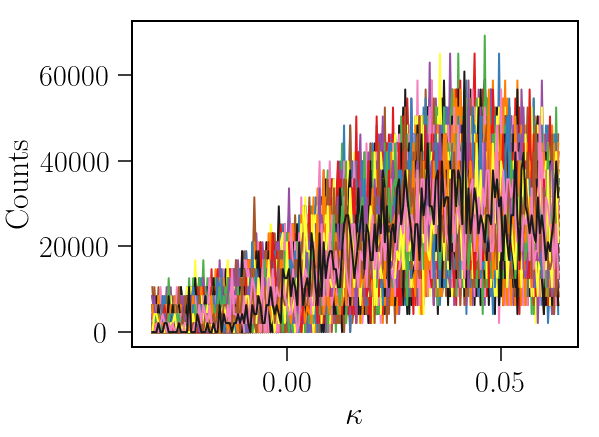

In [63]:
testell, testps, testkappa, testpc = get_PS_and_PC_arrays(table[0], 
                                      'powerspectrum_noisy', 'peakcounts_noisy')
plt.plot(testkappa, testpc.T)
plt.xlabel(r'$\kappa$');
plt.ylabel('Counts');

### 1.1. Computing the Covariance Matrix
We compute the covariance between each bin.

In [ ]:
def compute_covariance(row, )
if row['Model'] == '1a(fiducial)':
    PS_cov = np.cov(PS_realizations.T)
    PC_cov = np.cov(PC_realizations.T)

    nrealizations, nbins = PS_realizations.shape
    PS_correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    print( 'PS nr', nrealizations, 'nb', nbins, PS_correction )
    nrealizations, nbins = PC_realizations.shape
    PC_correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    print( 'PC nr', nrealizations, 'nb', nbins, PC_correction )

    # this 12.25/2e4 is from the LSST area divided by box, from Jia's email
    invcov_PS = PS_correction * np.linalg.inv(PS_cov * 12.25/sky_coverage)
    invcov_PC = PC_correction * np.linalg.inv(PC_cov * 12.25/sky_coverage)